In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%reload_ext autoreload
%autoreload 2

pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
%matplotlib inline

import gc
gc.enable()
base_dir = './data/'
from functions import utils
from pathlib import Path
from functions.prepare import (prepare_bureau, prepare_previous_application, raw_installments_payments,
                               prepare_train_test, one_hot_encoder,raw_previous_application,
                               prepare_pos_cash, prepare_installments_payments,raw_train_test,
                              prepare_credit_card_balance, timer, prepare_open_application)

from functions.cv_lgbm import train_model_LGBM

base_dir = Path(base_dir)

In [2]:
utils.cols_desc('DAYS_TERMINATION')

previous_application - Relative to application date of current application when was the expected termination of the previous application


In [5]:
application_train, application_test, y, categorical_feats = prepare_train_test(base_dir, 
                                                                               encode_categories='OHE')
unique_curr = set(application_test.SK_ID_CURR) | set(application_train.SK_ID_CURR)
application_train.set_index('SK_ID_CURR', inplace = True)
application_test.set_index('SK_ID_CURR', inplace = True)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Initial test 
(48744, 121) 121
Initial train 
(307511, 122) 122
Final test 
(48744, 265) 265
Final train 
(307511, 265) 265


In [6]:
data , y  = raw_train_test(base_dir)
unique_curr = data.SK_ID_CURR.unique()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2850: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Initial test 
(48744, 121) 121
Initial train 
(307511, 122) 122


In [5]:
previous_application = raw_previous_application(base_dir, unique_curr)
ins = raw_installments_payments(base_dir,unique_curr)

(1670214, 37)
remove Canceled, it seems that there is always a new application after those canceled
(1353895, 37)
Only in test/train set
Only in test/train set,  (1353895, 37)


In [3]:
utils.cols_desc('AMT_CREDIT')

application_{train|test} - Credit amount of the loan
previous_application - Final credit amount on the previous application. This differs from AMT_APPLICATION in a way that the AMT_APPLICATION is the amount for which the client initially applied for, but during our approval process he could have received different amount - AMT_CREDIT


In [41]:
previous_application.SK_ID_PREV.nunique(),previous_application.SK_ID_CURR.nunique()

(1353895, 338602)

In [23]:
ins_agg = prepare_open_application(base_dir,unique_curr)

(1670214, 37)
remove Canceled, it seems that there is always a new application after those canceled
(1353895, 37)
Only in test/train set
Only in test/train set,  (1353895, 37)
Shape open aplication (180696, 37)
Shape open aplication (180696, 37)
122770 (138111, 30)
Shape open aplication (122770, 29)


In [22]:
ins_agg.shape

(122770, 29)

In [140]:
previous_application[previous_application.DAYS_TERMINATION.isna()]

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,True,1,NaN,NaN,NaN,NaN,Approved,-164,NaN,NaN,Unaccompanied,Repeater,NaN,Cash,x-sell,Contact center,-1,NaN,36.0,low_action,Cash X-Sell: low,NaN,-134.0,916.0,NaN,NaN,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,True,1,NaN,NaN,NaN,NaN,Approved,-301,Cash through the bank,NaN,"Spouse, partner",Repeater,NaN,Cash,x-sell,Credit and cash offices,-1,NaN,12.0,high,Cash X-Sell: high,NaN,-271.0,59.0,NaN,NaN,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,True,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,NaN,Cash,walk-in,Credit and cash offices,-1,NaN,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
17,1285768,142748,Revolving loans,9000.000,180000.0,180000.0,NaN,180000.0,FRIDAY,13,True,1,NaN,NaN,NaN,NaN,Approved,-336,NaN,NaN,Unaccompanied,Repeater,NaN,Cards,x-sell,AP+ (Cash loan),6,NaN,0.0,NaN,Card X-Sell,-277.0,-257.0,NaN,NaN,NaN,0.0
18,2393109,396305,Cash loans,10181.700,180000.0,180000.0,NaN,180000.0,THURSDAY,14,True,1,NaN,NaN,NaN,NaN,Approved,-700,Cash through the bank,NaN,Unaccompanied,Repeater,NaN,Cash,x-sell,AP+ (Cash loan),6,NaN,24.0,low_normal,Cash X-Sell: low,NaN,NaN,NaN,NaN,NaN,NaN
19,1173070,199178,Cash loans,4666.500,45000.0,49455.0,NaN,45000.0,SATURDAY,16,True,1,NaN,NaN,NaN,Everyday expenses,Refused,-584,NaN,HC,NaN,Repeater,NaN,Cash,walk-in,AP+ (Cash loan),6,NaN,18.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
20,1506815,166490,Cash loans,25454.025,450000.0,491580.0,NaN,450000.0,MONDAY,6,True,1,NaN,NaN,NaN,NaN,Refused,-401,Cash through the bank,HC,Unaccompanied,Repeater,NaN,Cash,x-sell,Credit and cash offices,-1,NaN,24.0,low_normal,Cash X-Sell: low,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670196,1662123,398290,Consumer loans,NaN,57910.5,57910.5,0.0,57910.5,SATURDAY,9,True,1,0.0,NaN,NaN,NaN,Unused offer,-289,Cash through the bank,CLIENT,NaN,Repeater,Mobile,NaN,NaN,Country-wide,96,Connectivity,NaN,NaN,POS mobile with interest,NaN,NaN,NaN,NaN,NaN,NaN
1670197,1854636,184353,Consumer loans,15708.150,153220.5,153220.5,0.0,153220.5,SATURDAY,12,True,1,0.0,NaN,NaN,NaN,Refused,-636,Cash through the bank,LIMIT,NaN,Repeater,Construction Materials,POS,NaN,Regional / Local,673,Construction,12.0,middle,POS industry with interest,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
ins_prec.rename(columns= {'INSTAL_PREVSK_ID_CURR_FIRST':'SK_ID_CURR'}, inplace=True)

In [135]:
ins.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,DPD,DBD,PAYMENT_PERC,PAYMENT_DIFF
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360,0.0,7.0,1.000000,0.000
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525,0.0,0.0,1.000000,0.000
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000,0.0,0.0,1.000000,0.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130,0.0,8.0,1.000000,0.000
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585,17.0,0.0,0.997942,4.455


In [102]:
ins_prec.SK_ID_PREV.nunique(),ins_prec.SK_ID_CURR.nunique()

(958905, 336935)

In [103]:
drop_cols = ['CODE_REJECT_REASON','NAME_CONTRACT_STATUS','NAME_PORTFOLIO','NAME_CONTRACT_TYPE',
             'NFLAG_INSURED_ON_APPROVAL','AMT_GOODS_PRICE','NAME_CASH_LOAN_PURPOSE',
             'NAME_CLIENT_TYPE','NAME_GOODS_CATEGORY', 'CHANNEL_TYPE','SELLERPLACE_AREA',
             'NAME_SELLER_INDUSTRY','NUM_INSTALMENT_VERSION', 'AMT_APPLICATION',
             'AMT_DOWN_PAYMENT','RATE_INTEREST_PRIMARY','RATE_INTEREST_PRIVILEGED','NAME_TYPE_SUITE',
             'NAME_TYPE_SUITE','NAME_YIELD_GROUP','PRODUCT_COMBINATION',
             'NAME_PRODUCT_TYPE','NAME_PAYMENT_TYPE','RATE_DOWN_PAYMENT','HOUR_APPR_PROCESS_START',
            'WEEKDAY_APPR_PROCESS_START','FLAG_LAST_APPL_PER_CONTRACT','NFLAG_LAST_APPL_IN_DAY']

ins_prec.drop(columns=drop_cols, inplace=True)

In [104]:
ins_prec.DAYS_TERMINATION.fillna(0, inplace=True)

In [105]:
ins_prec.DAYS_TERMINATION.value_counts(dropna=False)

 0.0       4222635
-50.0         9774
-156.0        9593
-23.0         9486
-36.0         9476
-60.0         9440
-184.0        9357
            ...   
-2828.0          1
-2826.0          1
-2844.0          1
-2815.0          1
-2870.0          1
-2865.0          1
-2874.0          1
Name: DAYS_TERMINATION, Length: 2830, dtype: int64

In [121]:
ins.groupby('SK_ID_PREV')[['AMT_INSTALMENT','AMT_PAYMENT']].sum().join(previous_application.set_index('SK_ID_PREV')[['SK_ID_CURR','AMT_CREDIT','DAYS_TERMINATION']])

,AMT_INSTALMENT,AMT_PAYMENT,SK_ID_CURR,AMT_CREDIT,DAYS_TERMINATION
SK_ID_PREV,,,,,
1000001,68443.425,68443.425,158271.0,65124.00,-233.0
1000002,37235.565,37235.565,101962.0,35230.50,-1501.0
1000003,14854.050,14854.050,252457.0,52641.00,NaN
1000004,33523.155,33523.155,260094.0,30586.50,-672.0
1000005,161735.310,147021.705,176456.0,120307.50,-1415.0
1000007,56234.025,56234.025,256657.0,62856.00,NaN
1000008,262238.580,262238.580,152059.0,224325.00,-1034.0
...,...,...,...,...,...
2843493,79887.060,77637.060,337804.0,45000.00,NaN


In [108]:
ins_prec.head(40)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,DPD,DBD,PAYMENT_PERC,PAYMENT_DIFF,AMT_ANNUITY,AMT_CREDIT,DAYS_DECISION,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION
0,1054186,161674,6,-1180.0,-1187.0,6948.360,6948.360,0.0,7.0,1.0,0.0,6948.360,57141.0,-1361,12.0,NaN,-1330.0,-1000.0,-1000.0,-996.0
1,1054186,161674,2,-1300.0,-1307.0,6948.360,6948.360,0.0,7.0,1.0,0.0,6948.360,57141.0,-1361,12.0,NaN,-1330.0,-1000.0,-1000.0,-996.0
2,1054186,161674,8,-1120.0,-1175.0,6948.360,6948.360,0.0,55.0,1.0,0.0,6948.360,57141.0,-1361,12.0,NaN,-1330.0,-1000.0,-1000.0,-996.0
3,1054186,161674,12,-1000.0,-1033.0,6935.220,6935.220,0.0,33.0,1.0,0.0,6948.360,57141.0,-1361,12.0,NaN,-1330.0,-1000.0,-1000.0,-996.0
4,1054186,161674,3,-1270.0,-1275.0,6948.360,6948.360,0.0,5.0,1.0,0.0,6948.360,57141.0,-1361,12.0,NaN,-1330.0,-1000.0,-1000.0,-996.0
5,1054186,161674,1,-1330.0,-1338.0,6948.360,6948.360,0.0,8.0,1.0,0.0,6948.360,57141.0,-1361,12.0,NaN,-1330.0,-1000.0,-1000.0,-996.0
6,1054186,161674,10,-1060.0,-1125.0,6948.360,6948.360,0.0,65.0,1.0,0.0,6948.360,57141.0,-1361,12.0,NaN,-1330.0,-1000.0,-1000.0,-996.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,1137312,164489,1,-1714.0,-1744.0,5970.375,5970.375,0.0,30.0,1.0,0.0,5970.375,132381.0,-1746,24.0,NaN,-1714.0,-1024.0,-1294.0,-1285.0
34,1137312,164489,8,-1504.0,-1534.0,5970.375,5970.375,0.0,30.0,1.0,0.0,5970.375,132381.0,-1746,24.0,NaN,-1714.0,-1024.0,-1294.0,-1285.0


In [35]:
1036781-290678-26436

719667

In [10]:
previous_application.NAME_CONTRACT_STATUS.value_counts(dropna=  False)

Approved        1036781
Refused          290678
Unused offer      26436
Name: NAME_CONTRACT_STATUS, dtype: int64

In [9]:
set(ins.SK_ID_PREV).__len__(), len(set(previous_application.SK_ID_PREV))

(997752, 1353895)

In [41]:
drop_cols = ['CODE_REJECT_REASON','FLAG_LAST_APPL_PER_CONTRACT']

In [48]:
ins_prec[ins_prec.RATE_INTEREST_PRIMARY.isna()]

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360,Consumer loans,6948.360,57141.0,57141.0,0.0,57141.0,SATURDAY,13,True,1,0.000000,NaN,NaN,NaN,Approved,-1361,Cash through the bank,NaN,Family,Repeater,Consumer Electronics,POS,NaN,Country-wide,1200,Consumer electronics,12.0,high,POS household with interest,NaN,-1330.0,-1000.0,-1000.0,-996.0,0.0
1,1054186,161674,1.0,2,-1300.0,-1307.0,6948.360,6948.360,Consumer loans,6948.360,57141.0,57141.0,0.0,57141.0,SATURDAY,13,True,1,0.000000,NaN,NaN,NaN,Approved,-1361,Cash through the bank,NaN,Family,Repeater,Consumer Electronics,POS,NaN,Country-wide,1200,Consumer electronics,12.0,high,POS household with interest,NaN,-1330.0,-1000.0,-1000.0,-996.0,0.0
2,1054186,161674,1.0,8,-1120.0,-1175.0,6948.360,6948.360,Consumer loans,6948.360,57141.0,57141.0,0.0,57141.0,SATURDAY,13,True,1,0.000000,NaN,NaN,NaN,Approved,-1361,Cash through the bank,NaN,Family,Repeater,Consumer Electronics,POS,NaN,Country-wide,1200,Consumer electronics,12.0,high,POS household with interest,NaN,-1330.0,-1000.0,-1000.0,-996.0,0.0
3,1054186,161674,1.0,12,-1000.0,-1033.0,6935.220,6935.220,Consumer loans,6948.360,57141.0,57141.0,0.0,57141.0,SATURDAY,13,True,1,0.000000,NaN,NaN,NaN,Approved,-1361,Cash through the bank,NaN,Family,Repeater,Consumer Electronics,POS,NaN,Country-wide,1200,Consumer electronics,12.0,high,POS household with interest,NaN,-1330.0,-1000.0,-1000.0,-996.0,0.0
4,1054186,161674,1.0,3,-1270.0,-1275.0,6948.360,6948.360,Consumer loans,6948.360,57141.0,57141.0,0.0,57141.0,SATURDAY,13,True,1,0.000000,NaN,NaN,NaN,Approved,-1361,Cash through the bank,NaN,Family,Repeater,Consumer Electronics,POS,NaN,Country-wide,1200,Consumer electronics,12.0,high,POS household with interest,NaN,-1330.0,-1000.0,-1000.0,-996.0,0.0
5,1054186,161674,1.0,1,-1330.0,-1338.0,6948.360,6948.360,Consumer loans,6948.360,57141.0,57141.0,0.0,57141.0,SATURDAY,13,True,1,0.000000,NaN,NaN,NaN,Approved,-1361,Cash through the bank,NaN,Family,Repeater,Consumer Electronics,POS,NaN,Country-wide,1200,Consumer electronics,12.0,high,POS household with interest,NaN,-1330.0,-1000.0,-1000.0,-996.0,0.0
6,1054186,161674,1.0,10,-1060.0,-1125.0,6948.360,6948.360,Consumer loans,6948.360,57141.0,57141.0,0.0,57141.0,SATURDAY,13,True,1,0.000000,NaN,NaN,NaN,Approved,-1361,Cash through the bank,NaN,Family,Repeater,Consumer Electronics,POS,NaN,Country-wide,1200,Consumer electronics,12.0,high,POS household with interest,NaN,-1330.0,-1000.0,-1000.0,-996.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12354568,2090546,438373,4.0,1,-13.0,NaN,35246.880,NaN,Consumer loans,35246.880,193500.0,193500.0,0.0,193500.0,WEDNESDAY,15,True,1,0.000000,NaN,NaN,NaN,Approved,-43,Cash through the bank,NaN,"Spouse, partner",Refreshed,Clothing and Accessories,POS,NaN,Stone,30,Clothing,6.0,low_normal,POS industry with interest,NaN,-13.0,137.0,NaN,NaN,0.0
12354569,2682640,418699,3.0,1,-24.0,NaN,42419.205,NaN,Consumer loans,4720.590,41562.0,41562.0,0.0,41562.0,WEDNESDAY,15,True,1,0.000000,NaN,NaN,NaN,Approved,-57,Cash through the bank,NaN,NaN,Repeater,Mobile,POS,NaN,Country-wide,25,Connectivi

In [2]:
def main():
    application_train, application_test, y, categorical_feats = prepare_train_test(base_dir, 
                                                                                   encode_categories='OHE')
    unique_curr = set(application_test.SK_ID_CURR) | set(application_train.SK_ID_CURR)
    application_train.set_index('SK_ID_CURR', inplace = True)
    application_test.set_index('SK_ID_CURR', inplace = True)
    
    with timer("Process bureau and bureau_balance"):
        bureau = prepare_bureau(base_dir)
        print("Bureau bureau shape:", bureau.shape)
        application_train = application_train.join(bureau, how='left')
        application_test = application_test.join(bureau, how='left')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        previous_application = prepare_previous_application(base_dir, unique_curr)
        print("Previous applications df shape:", previous_application.shape)
        application_train = application_train.join(previous_application, how='left')
        application_test = application_test.join(previous_application, how='left')
        del previous_application
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = prepare_pos_cash(base_dir)
        print("Pos-cash balance df shape:", pos.shape)
        application_train = application_train.join(pos, how='left')
        application_test = application_test.join(pos, how='left')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        installments = prepare_installments_payments(base_dir, unique_curr)
        print("Installments payments df shape:", installments.shape)
        application_train = application_train.join(installments, how='left')
        application_test = application_test.join(installments, how='left')
        del installments
        gc.collect()
    with timer("Process credit card balance"):
        credit_card = prepare_credit_card_balance(base_dir)
        print("Credit card balance df shape:", credit_card.shape)
        application_train = application_train.join(credit_card, how='left')
        application_test = application_test.join(credit_card, how='left')
        del credit_card
        gc.collect()
        
    with timer("Process prepare_open_application"):
        ins_agg = prepare_open_application(base_dir, unique_curr)
        print("Credit card balance df shape:", ins_agg.shape)
        application_train = application_train.join(ins_agg, how='left',rsuffix='_OPEN')
        application_test = application_test.join(ins_agg, how='left',rsuffix='_OPEN')
        del ins_agg
        gc.collect()
    return application_train.reset_index(), application_test.reset_index(), y
    


with timer("Full model run"):
    application_train, application_test, y = main()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.


Initial test 
(48744, 121) 121
Initial train 
(307511, 122) 122
Final test 
(48744, 265) 265
Final train 
(307511, 265) 265
bureau_balance shape :  (27299925, 11) - unique 817395
Bureau bureau shape: (305811, 95)
Process bureau and bureau_balance - done in 23s
(1670214, 37)
remove Canceled, it seems that there is always a new application after those canceled
(1353895, 37)
Only in test/train set
Only in test/train set,  (1353895, 37)
Final, 
(338602, 203) 203
Previous applications df shape: (338602, 203)
Process previous_applications - done in 17s
pos_cash shape :  (10001358, 8)
pos_cash shape :  (337252, 19)
Pos-cash balance df shape: (337252, 19)
Process POS-CASH balance - done in 12s
installments shape :  (339587, 36)
Installments payments df shape: (339587, 36)
Process installments payments - done in 33s
credit card shape :  (103558, 113)
Credit card balance df shape: (103558, 113)
Process credit card balance - done in 15s
(1670214, 37)
remove Canceled, it seems that there is always

In [3]:
application_train.shape

(307511, 760)

In [4]:
y.shape

(307511, 2)

In [5]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [6]:
oof_preds, df_oof_preds, test_preds, importances, score = train_model_LGBM(application_train, 
                                                                           y['TARGET'], application_test,
                                                                           folds , 
                                                                           ignore_cols_=['SK_ID_CURR'])

Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.749707	valid_1's auc: 0.738454
[100]	training's auc: 0.759099	valid_1's auc: 0.744369
[150]	training's auc: 0.772074	valid_1's auc: 0.753891
[200]	training's auc: 0.783913	valid_1's auc: 0.762435
[250]	training's auc: 0.79481	valid_1's auc: 0.769797
[300]	training's auc: 0.803343	valid_1's auc: 0.775259
[350]	training's auc: 0.810358	valid_1's auc: 0.778958
[400]	training's auc: 0.816215	valid_1's auc: 0.781656
[450]	training's auc: 0.821449	valid_1's auc: 0.783802
[500]	training's auc: 0.826236	valid_1's auc: 0.785699
[550]	training's auc: 0.830548	valid_1's auc: 0.786926
[600]	training's auc: 0.834597	valid_1's auc: 0.788042
[650]	training's auc: 0.83851	valid_1's auc: 0.788984
[700]	training's auc: 0.842143	valid_1's auc: 0.789719
[750]	training's auc: 0.845475	valid_1's auc: 0.790415
[800]	training's auc: 0.848951	valid_1's auc: 0.79098
[850]	training's auc: 0.852137	valid_1's auc: 0.791374
[900]	

In [7]:
# Save test predictions
base_name = '5x-LGB-run-01-open_apl'

now = datetime.now()
score = str(round(score, 6)).replace('.', '')
sub_file = f'subs/submission_{base_name}_' + score + '_' + str(now.strftime('%Y-%m-%d-%H-%M')) + '.csv.gz'
test_preds.to_csv(sub_file, index=False, compression  = 'gzip' )
oof_file = f'subs/train_{base_name}-oof_' + score + '_' + str(now.strftime('%Y-%m-%d-%H-%M')) + '.csv.gz'
df_oof_preds.to_csv(oof_file, index=False, compression  = 'gzip')
# Display a few graphs

In [8]:
folds_idx = [(trn_idx, val_idx)
             for trn_idx, val_idx in folds.split(application_train, y['TARGET'])]

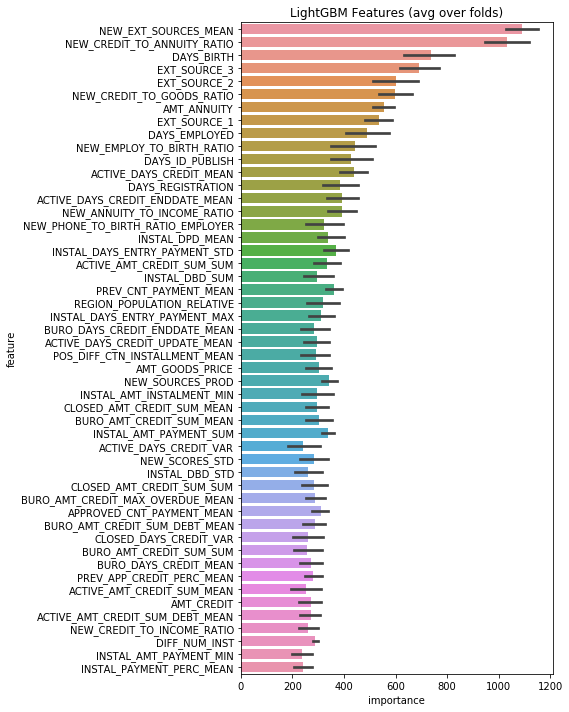

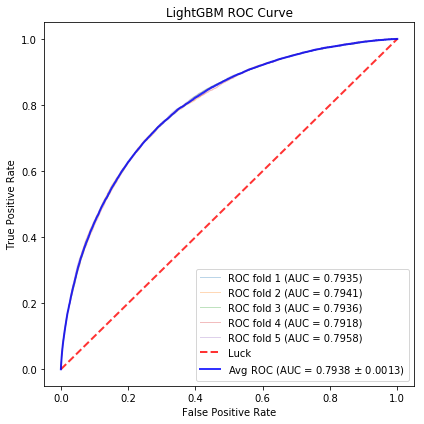

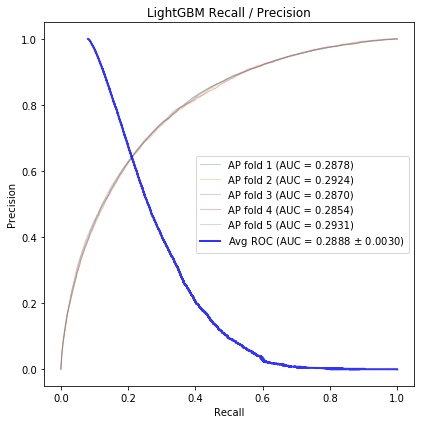

In [9]:
utils.display_importances(feature_importance_df_=importances)
utils.display_roc_curve(y_=y['TARGET'], oof_preds_=oof_preds, folds_idx_=folds_idx)
utils.display_precision_recall(y_=y['TARGET'], oof_preds_=oof_preds, folds_idx_=folds_idx)

In [10]:
!!kaggle competitions submit -c home-credit-default-risk -f {sub_file} -m "LGBM 750 features cv5"

['Successfully submitted to Home Credit Default Risk']

In [11]:
import os

In [13]:
train_stack = [i for i in os.listdir('subs/') if 'train_5x' in i]
subs_stack = [i for i in os.listdir('subs/') if 'submission_5x' in i]

In [15]:
subs_stack, train_stack

(['submission_5x-LGB-run-01-only_application_0770125_2018-07-09-16-51.csv.gz',
  'submission_5x-average-LGB-run-01-v1_0791858_2018-07-08-18-44.csv.gz',
  'submission_5x-average-LGB-run-01-v1_0790904_2018-07-08-19-06.csv.gz',
  'submission_5x-LGB-run-01-open_apl_0793758_2018-07-15-19-26.csv.gz'],
 ['train_5x-LGB-run-01-open_apl-oof_0793758_2018-07-15-19-26.csv.gz',
  'train_5x-LGB-run-01-only_application-oof_0770125_2018-07-09-16-51.csv.gz',
  'train_5x-LGB-run-01-v1-oof_0791858_2018-07-08-18-44.csv.gz',
  'train_5x-LGB-run-01-v1-oof_0790904_2018-07-08-19-06.csv.gz'])

In [92]:
mines_test = ['submission_5x-average-LGB-run-01-v1_0791858_2018-07-08-18-44.csv.gz',
              'submission_5x-LGB-run-01-open_apl_0793758_2018-07-15-19-26.csv.gz',
              'submission_5x-LGB-run-01-only_application_0770125_2018-07-09-16-51.csv.gz',
              'submission_5x-average-LGB-run-01-v1_0790904_2018-07-08-19-06.csv.gz', 
              ]

mines_train = ['train_5x-LGB-run-01-v1-oof_0791858_2018-07-08-18-44.csv.gz',
               'train_5x-LGB-run-01-open_apl-oof_0793758_2018-07-15-19-26.csv.gz',
               'train_5x-LGB-run-01-only_application-oof_0770125_2018-07-09-16-51.csv.gz',
               'train_5x-LGB-run-01-v1-oof_0790904_2018-07-08-19-06.csv.gz'
             ]

outs = [pd.read_csv('subs/'+f, index_col=0) for f in mines_train]
mines_train  = pd.concat(outs, axis=1)
y = mines_train.pop('TARGET')
y = y.iloc[:,0]
cols = list(map(lambda x: "target_" + str(x), range(len(mines_train.columns))))
mines_train.columns = cols

outs = [pd.read_csv('subs/'+f, index_col=0) for f in mines_test]
mines_test  = pd.concat(outs, axis=1)
cols = list(map(lambda x: "target_" + str(x), range(len(mines_test.columns))))
mines_test.columns = cols



train_rank = (mines_train.rank() / mines_train.shape[0])
test_rank = (mines_test.rank() / mines_test.shape[0])

In [93]:
test_rank.head()

,target_0,target_1,target_2,target_3
SK_ID_CURR,,,,
100001,0.334092,0.374467,0.282599,0.279316
100005,0.864619,0.850977,0.714714,0.866466
100013,0.246000,0.290682,0.112629,0.238183
100028,0.361993,0.404132,0.390879,0.424791
100038,0.846155,0.862527,0.870076,0.845048


In [94]:
train_rank.reset_index(drop=True).head()

,target_0,target_1,target_2,target_3
0,0.961666,0.960545,0.990417,0.940815
1,0.097697,0.119254,0.560178,0.132122
2,0.294136,0.294113,0.433178,0.218903
3,0.461590,0.250580,0.342528,0.473762
4,0.684307,0.611663,0.793978,0.667687


In [73]:
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [88]:
dict(C=Cs)

{'C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
        3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
        1.29154967e+03, 1.00000000e+04])}

In [89]:
# Prediction
Cs = np.logspace(-4, 4, 10)
# Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = LogisticRegressionCV(Cs,cv=5,n_jobs=36)
estimator.fit(train_rank.values, y.values)

LogisticRegressionCV(Cs=array([1.00000e-04, 7.74264e-04, 5.99484e-03, 4.64159e-02, 3.59381e-01,
       2.78256e+00, 2.15443e+01, 1.66810e+02, 1.29155e+03, 1.00000e+04]),
           class_weight=None, cv=5, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=36, penalty='l2', random_state=None, refit=True,
           scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [90]:
estimator.predict() 

{1: array([[0.91927223, 0.91927223, 0.91927223, 0.91927223, 0.91927223,
         0.91927223, 0.91927223, 0.91927223, 0.91927223, 0.91927223],
        [0.91927092, 0.91927092, 0.91927092, 0.91927092, 0.91927092,
         0.91927092, 0.91927092, 0.91927092, 0.91927092, 0.91927092],
        [0.91927092, 0.91927092, 0.91927092, 0.91927092, 0.91927092,
         0.91927092, 0.91927092, 0.91927092, 0.91927092, 0.91927092],
        [0.91927092, 0.91927092, 0.91927092, 0.91927092, 0.91927092,
         0.91927092, 0.91927092, 0.91927092, 0.91927092, 0.91927092],
        [0.91927092, 0.91927092, 0.91927092, 0.91927092, 0.91927092,
         0.91927092, 0.91927092, 0.91927092, 0.91927092, 0.91927092]])}

In [95]:
test_rank['TARGET'] = estimator.predict_proba(test_rank.values)[:,0]

In [96]:
test_rank.reset_index()[['SK_ID_CURR','TARGET']]

,SK_ID_CURR,TARGET
0,100001,0.942107
1,100005,0.881471
2,100013,0.949529
3,100028,0.935291
4,100038,0.876723
5,100042,0.928719
6,100057,0.962018
...,...,...
48737,456189,0.874756
48738,456202,0.894961


In [66]:
train_rank.values

array([[0.96166641, 0.9605445 , 0.9904166 , 0.94081513],
       [0.09769732, 0.11925427, 0.56017834, 0.1321221 ],
       [0.29413582, 0.29411306, 0.433178  , 0.21890274],
       ...,
       [0.49235637, 0.51366293, 0.4822299 , 0.47892271],
       [0.57341689, 0.53696616, 0.65114419, 0.63995434],
       [0.59970863, 0.61502841, 0.70618612, 0.42116867]])

In [64]:
y

SK_ID_CURR
100002    1
100003    0
100004    0
100006    0
100007    0
100008    0
100009    0
         ..
456248    0
456249    0
456251    0
456252    0
456253    0
456254    1
456255    0
Name: TARGET, Length: 307511, dtype: int64

In [97]:
test_rank =test_rank.mean(axis=1).reset_index()
test_rank.columns = ['SK_ID_CURR','TARGET']

test_rank.to_csv('teste_rank_ens4.csv.gz', index=False, compression  = 'gzip' )

In [98]:
!!kaggle competitions submit -c home-credit-default-risk -f 'teste_rank_ens4.csv.gz' -m "LGBM 750 features cv5"

['Successfully submitted to Home Credit Default Risk']